# Style Transfer:

O estilo de transferência (style transfer) é uma técnica na área de processamento de imagens e visão computacional que permite combinar o conteúdo de uma imagem de entrada com o estilo de outra imagem. Isso é alcançado otimizando uma imagem de destino para minimizar a diferença entre o conteúdo da imagem de entrada e o estilo da imagem de estilo, ao mesmo tempo em que mantém a aparência geral da imagem de destino. O resultado é uma nova imagem que combina o conteúdo de uma imagem com o estilo de outra, criando um efeito artístico único.

Este código é um exemplo de como aplicar a transferência de estilo de arte usando PyTorch. A transferência de estilo é uma técnica que combina o conteúdo de uma imagem de conteúdo com o estilo de uma imagem de estilo para criar uma nova imagem que tenha o conteúdo da imagem de conteúdo e o estilo da imagem de estilo.

download das imagens de conteúdo e estilo da internet usando o comando wget.

In [ ]:
# Baixando as imagens de conteúdo e estilo
!wget -O content.jpg https://www.scotsman.com/webimg/b25lY21zOmRmYmExYzE4LTZhY2ItNDBkZS1iMTU1LWY4YTVlZWNmYTdkYzowOTcxZDZlOC00MDc1LTQzYzItOWEyOC00YjNlNzFiY2Y1YzI=.jpg?width=1200&enable=upscale
!wget -O style.jpg https://static.todamateria.com.br/upload/ab/ap/abaporu1928-cke.jpg?auto_optimize=low


--2023-09-15 01:31:33--  https://www.scotsman.com/webimg/b25lY21zOmRmYmExYzE4LTZhY2ItNDBkZS1iMTU1LWY4YTVlZWNmYTdkYzowOTcxZDZlOC00MDc1LTQzYzItOWEyOC00YjNlNzFiY2Y1YzI=.jpg?width=1200
Resolving www.scotsman.com (www.scotsman.com)... 104.18.35.12, 172.64.152.244, 2606:4700:4400::ac40:98f4, ...
Connecting to www.scotsman.com (www.scotsman.com)|104.18.35.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80259 (78K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>]  78.38K  --.-KB/s    in 0.008s  

2023-09-15 01:31:34 (10.2 MB/s) - ‘content.jpg’ saved [80259/80259]

--2023-09-15 01:31:34--  https://static.todamateria.com.br/upload/ab/ap/abaporu1928-cke.jpg?auto_optimize=low
Resolving static.todamateria.com.br (static.todamateria.com.br)... 143.244.50.214, 2400:52e0:1a01::999:1
Connecting to static.todamateria.com.br (static.todamateria.com.br)|143.244.50.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

importa as bibliotecas necessárias

In [1]:
!pip install watermark matplotlib==3.7.1 torch==2.0.1 torchvision==0.15.2 torchaudio pillow==9.4.0 requests==2.31.0 --index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import time
import PIL
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Version 0" --iversions

Author: Version 0

matplotlib : 3.7.1
torch      : 2.0.1+cu118
numpy      : 1.23.5
torchvision: 0.15.2+cu118
PIL        : 9.4.0
requests   : 2.31.0



# Modelo

Define a arquitetura da rede neural VGG-19 (pré-treinada com pesos da ImageNet) e congela todos os seus parâmetros para evitar que sejam atualizados durante o treinamento.

Os pesos da rede neural VGG-19 são congelados (ou seja, definidos como não treináveis) neste código por várias razões:

1. Transferência de Aprendizado: A VGG-19 é uma rede neural pré-treinada com pesos
que foram treinados em um grande conjunto de dados (ImageNet) para classificação de imagens. Esses pesos capturam características gerais de baixo e alto nível em imagens, como bordas, texturas e formas. Ao congelar esses pesos, você pode aproveitar o conhecimento aprendido pela VGG-19 em tarefas de processamento de imagem sem modificar esses conhecimentos.

2. Economia Computacional: Treinar uma rede neural como a VGG-19 a partir do zero pode ser computacionalmente intensivo e demorado. Congelar os pesos permite que você economize tempo e recursos computacionais, pois não precisa atualizar esses pesos durante o treinamento.

3. Preservação de Conhecimento: Congelar os pesos da VGG-19 ajuda a preservar as representações de alto nível que a rede já aprendeu. Isso é especialmente importante em transferência de estilo, onde o objetivo é preservar o conteúdo da imagem de conteúdo enquanto aplica o estilo da imagem de estilo.

4. Foco na Estilização: Ao congelar os pesos da VGG-19, o foco do treinamento é principalmente na otimização da imagem de destino para combinar o conteúdo e o estilo, em vez de ajustar os pesos da rede VGG-19 em si.

In [ ]:
vgg = models.vgg19(pretrained=True).features


for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

função load_image para carregar e pré-processar uma imagem.

redimensiona a imagem para que a dimensão máxima seja de 400 pixels, converte em um tensor e a normaliza com média e desvio padrão específicos.

In [ ]:
def load_image(img_path, max_size=400, shape=None):

    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [ ]:
content = load_image('/content/content.jpg').to(device)
style = load_image('/content/style.jpg', shape=content.shape[-2:]).to(device)

In [ ]:
 # A função im_convert é definida para converter um tensor em uma imagem NumPy para exibição.
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

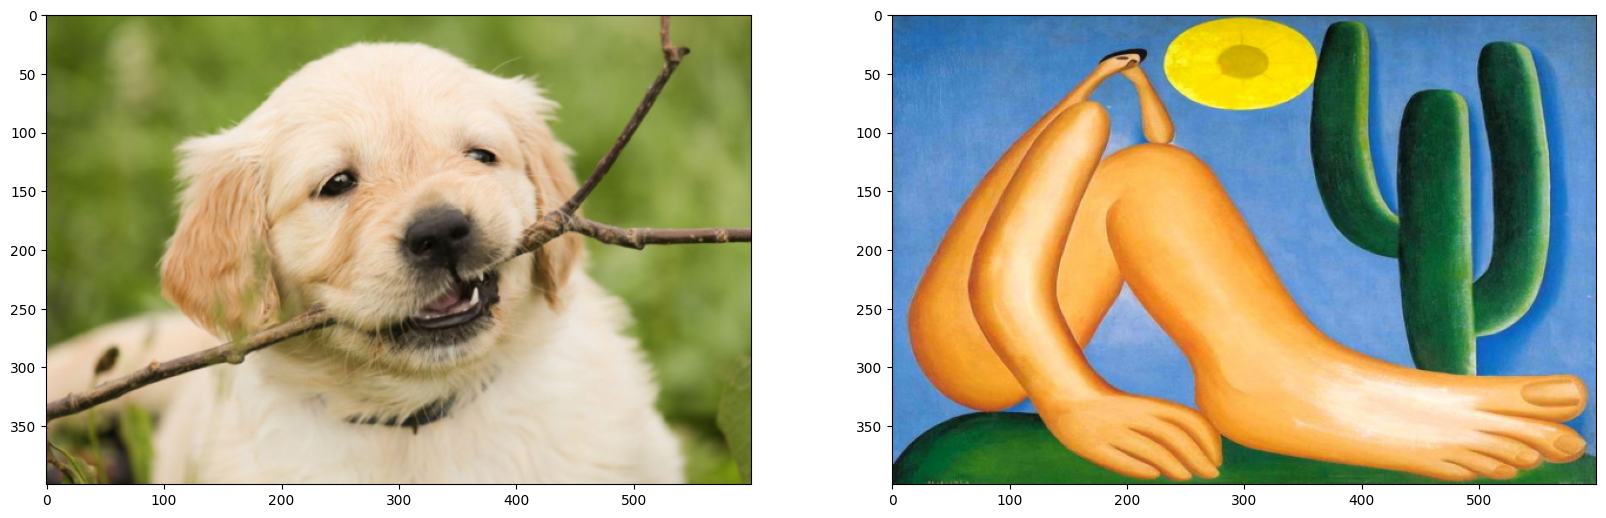

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

A função get_features é usada para extrair características (representações) de uma imagem ao passá-la por uma rede neural, neste caso, a rede neural VGG-19 pré-treinada. A principal finalidade dessa função é obter as ativações (saídas intermediárias) de camadas específicas da rede para a imagem de entrada, pois essas ativações contêm informações importantes sobre o conteúdo e o estilo da imagem.

In [ ]:
def get_features(image, model, layers=None):


    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1',
            }



    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

função gram_matrix calcula a matriz de Gram para um tensor, que é usada para medir o estilo de uma imagem.

In [ ]:
def gram_matrix(tensor):

    b,d,h,w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())

    return gram

As características de conteúdo e estilo são extraídas usando a função get_features, e as matrizes de Gram são calculadas para as características de estilo.

A imagem de destino é inicializada como uma cópia da imagem de conteúdo, que será otimizada para combinar o conteúdo e o estilo.

In [ ]:
# extrair as características de conteúdo e estilo das imagens de conteúdo e estilo.
# content_features conterá as características da imagem de conteúdo.
content_features = get_features(content, vgg)

# style_features conterá as características da imagem de estilo.
style_features = get_features(style, vgg)

# Calculando Matrizes de Gram para Estilo:
# calcular as matrizes de Gram para as características de estilo extraídas da
# imagem de estilo.

# As matrizes de Gram são usadas para medir o estilo da imagem e representam
# como as características estão correlacionadas umas com as outras em diferentes
# camadas da rede.
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Imagem de Destino para Otimização
target = content.clone().requires_grad_(True).to(device)


# Definir os pesos para as diferentes camadas da rede que contribuirão para a
# perda de estilo.
# Cada camada possui um peso que determina a importância relativa daquela camada
# para a perda de estilo total. Camadas mais profundas costumam ter pesos menores.
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}


content_weight = 1
style_weight = 1e8

O loop principal executa a otimização da imagem de destino para minimizar a perda total, que é uma combinação da perda de conteúdo e a perda de estilo.

A cada iteração, a perda total é calculada e a imagem de destino é atualizada usando o otimizador Adam.

A cada 30 iterações, a imagem de destino é exibida.

O código mede o tempo total de execução e imprime-o ao final.

In [ ]:
start = time.time()
show_every = 30

optimizer = optim.Adam([target], lr=0.003)
steps = 300

for ii in range(1, steps+1):


    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape

        target_gram = gram_matrix(target_feature)

        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss / (d * h * w)


    total_loss = style_weight*style_loss + content_weight*content_loss


    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()
        print(f"Finishing {ii} epoch in: {round(((time.time() - start)/60),2)} minutes")

print(f"completed in {round(((time.time() - start)/60),2)} minutes")

Output hidden; open in https://colab.research.google.com to view.